In [80]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None

In [81]:
mid_fin = pd.read_csv("mt_final_grade.csv", low_memory=False)

In [82]:
#filtering, renaming
mid_fin["OFFICIAL_GRADE"] = np.where( mid_fin["OFFICIAL_GRADE"].isnull()==True, "DR", mid_fin["OFFICIAL_GRADE"])
mid_fin = mid_fin.rename(columns={"GRADE" : "Midterm_Grade", "ACT_MATH": "MATH_T"})
mid_fin.drop(['COURSE_TITLE', 'ENROLL_DROP_DATE', "ID", "NAME", "RMDL_MATH", "RMDL_ENGL"], axis=1, inplace=True)

In [83]:
#groupby to fill each student with their test credits
mid_fin["TERM_TEST_CREDITS"] = mid_fin.groupby(["CAMPUS_ID", "TERM"], as_index=False)["TERM_TEST_CREDITS"].transform(lambda x: x.max())
mid_fin['TERM_TEST_CREDITS'] = mid_fin.groupby('CAMPUS_ID')['TERM_TEST_CREDITS'].transform(lambda x: x.unique().sum())

In [84]:
#put ACT and SAT scores on same scale
scaler = StandardScaler()
scaler.fit(mid_fin[["MATH_T", "SAT_MATH"]]) #manual: (x-x.mean()) / x.std()
mid_fin[["MATH_T", "SAT_MATH"]] = scaler.transform(mid_fin[["MATH_T", "SAT_MATH"]])
mid_fin["MATH_T"] = np.where(mid_fin["MATH_T"].isnull(), mid_fin["SAT_MATH"], mid_fin["MATH_T"])
mid_fin.drop("SAT_MATH", axis=1, inplace=True)

In [85]:
mid_fin.to_excel("clean_mid_fin.xlsx", "clean_mid_fin.xlsx")

# Models

In [7]:
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)

## Dropped or Not

In [8]:
#binomial logistic of droped or not dropped 
import statsmodels.formula.api as smf

mid_fin1= mid_fin.copy(deep=True)
mid_fin1= mid_fin1[ mid_fin["MATH_T"].isnull()==False] #drop obs were students don't have any standardized math grade shown

drop = ["DR", "N", "NW", "UD", "I", "NR"]

dont_care = ["A", "AB", "B", "BC"]
mid_fin1 = mid_fin1[ mid_fin1["Midterm_Grade"].isin(dont_care)==False]

In [9]:
#midterm as letters, offical grade binary
mid_fin1["OFFICIAL_GRADE"] = np.where(mid_fin1["OFFICIAL_GRADE"].isin(drop), "0", "1")

mid_fin1["OFFICIAL_GRADE"] = pd.to_numeric(mid_fin1["OFFICIAL_GRADE"])

lr_fit = smf.logit("OFFICIAL_GRADE ~ SUBJECT_CODE + C(Midterm_Grade, Treatment(reference='C')) + CREDIT_TOTAL + CATALOG_NUMBER + TERM_TEST_CREDITS + MATH_T", data=mid_fin1).fit()

y=mid_fin1["OFFICIAL_GRADE"] #binary
X=mid_fin1[["MATH_T", "CATALOG_NUMBER", "TERM_TEST_CREDITS", "SUBJECT_CODE", "Midterm_Grade", "CREDIT_TOTAL"]]

print(lr_fit.summary())

lr_fit.predict(X) #giving predictive probability

X_train, X_test_1, y_train, y_test_1 = train_test_split(X, y)

mid_fin1["Pred prob"] = lr_fit.predict(X)
mid_fin1["Pred"] = np.where(mid_fin1["Pred prob"]>.5,1,0)

confusion_matrix(y, mid_fin1["Pred"])
#    P
# R  00 01
#    10 11

#pd.crosstab(mid_fin1["OFFICIAL_GRADE"], columns=mid_fin1["TERM"])

         Current function value: 0.242021
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:         OFFICIAL_GRADE   No. Observations:                 1464
Model:                          Logit   Df Residuals:                     1451
Method:                           MLE   Df Model:                           12
Date:                Mon, 02 Oct 2023   Pseudo R-squ.:                  0.1562
Time:                        11:48:58   Log-Likelihood:                -354.32
converged:                      False   LL-Null:                       -419.93
Covariance Type:            nonrobust   LLR p-value:                 3.513e-22
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            4.4050      1.1

C:\Users\kmconrad3\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([[   5,  117],
       [   2, 1340]], dtype=int64)

In [10]:
#MIDTERM AS NUMBERS, official binary, dropped some more types
mid_fin11= mid_fin.copy(deep=True)
mid_fin11= mid_fin1[ mid_fin["MATH_T"].isnull()==False] #drop obs were students don't have any standardized math grade shown
drop = ["DR", "N", "NW", "UD", "I", "NR"]
dont_care = ["A", "AB", "B", "BC", "NR", "W", "CR", "SD", "S"]

mid_fin11 = mid_fin11[ mid_fin11["Midterm_Grade"].isin(dont_care)==False]
mid_fin11["OFFICIAL_GRADE"] = np.where(mid_fin11["OFFICIAL_GRADE"].isin(drop), "0", "1")

mid_fin11["OFFICIAL_GRADE"] = pd.to_numeric(mid_fin1["OFFICIAL_GRADE"])

mid_fin11["Midterm_Grade"] = pd.to_numeric(mid_fin11["Midterm_Grade"].replace("A", 4.0).replace("AB", 3.5).replace("B", 3.0).replace("BC", 2.5).replace("C", 2.0).replace("D", 1.0).replace("F", 0.0) \
.replace("I", 0.0).replace("UD", 0.0).replace("NW", 0.0).replace("DR", 0.0).replace("N", 0.0))

lr_fitt = smf.logit("OFFICIAL_GRADE ~ SUBJECT_CODE + Midterm_Grade + CREDIT_TOTAL + CATALOG_NUMBER + TERM_TEST_CREDITS + MATH_T", data=mid_fin11).fit()

y=mid_fin11["OFFICIAL_GRADE"] #binary
X=mid_fin11[["MATH_T", "CATALOG_NUMBER", "TERM_TEST_CREDITS", "SUBJECT_CODE", "Midterm_Grade", "CREDIT_TOTAL"]]

print(lr_fitt.summary())

lr_fitt.predict(X) #giving predictive probability

mid_fin11["Pred prob"] = lr_fitt.predict(X)
mid_fin11["Pred"] = np.where(mid_fin11["Pred prob"]>.5,1,0)

confusion_matrix(y, mid_fin11["Pred"])
#    P
# R  00 01
#    10 11

C:\Users\kmconrad3\AppData\Local\Temp\ipykernel_16740\1748992134.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mid_fin11= mid_fin1[ mid_fin["MATH_T"].isnull()==False] #drop obs were students don't have any standardized math grade shown


Optimization terminated successfully.
         Current function value: 0.256954
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         OFFICIAL_GRADE   No. Observations:                 1407
Model:                          Logit   Df Residuals:                     1400
Method:                           MLE   Df Model:                            6
Date:                Mon, 02 Oct 2023   Pseudo R-squ.:                  0.1285
Time:                        11:48:59   Log-Likelihood:                -361.53
converged:                       True   LL-Null:                       -414.86
Covariance Type:            nonrobust   LLR p-value:                 1.019e-20
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.3122      1.094      2.113      0.035       0.168       4.457
SUBJECT_

array([[   0,  122],
       [   0, 1285]], dtype=int64)

In [11]:
mid_fin1["OFFICIAL_GRADE"].value_counts()

OFFICIAL_GRADE
1    1342
0     122
Name: count, dtype: int64

array([<Axes: title={'center': 'Pred prob'}>], dtype=object)

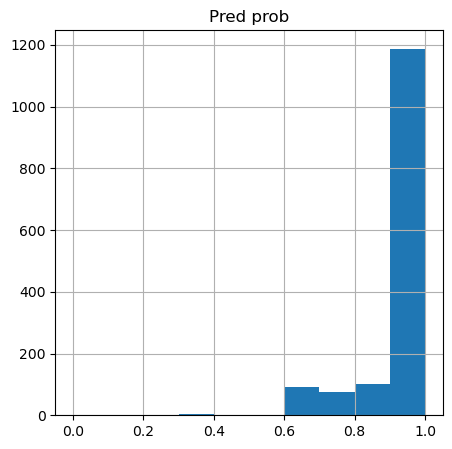

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
mid_fin1[["Pred prob"]].hist(ax=ax) #very skewed data

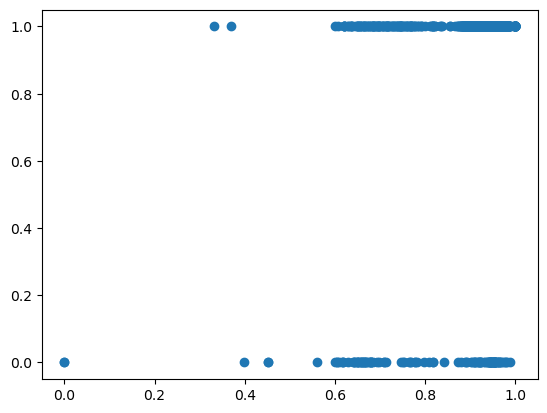

In [13]:
plt.scatter(x= mid_fin1["Pred prob"], y=mid_fin1["OFFICIAL_GRADE"])

In [15]:
#IGNORE
# #Can only do numeric columns for these 2 functions!!
# #this is stupid because doesn't include midterm grade
import statsmodels.api as sm
# y=mid_fin1["OFFICIAL_GRADE"] #binary
# X=mid_fin1[["MATH_T", "CATALOG_NUMBER", "TERM_TEST_CREDITS", "SUBJECT_CODE"]]
# X_train, X_test, y_train, y_test = train_test_split(X, y)

# log_reg = sm.Logit(y,X).fit() #easier to fit this way especially with train/test sets
# print(log_reg.summary())

# lr = LogisticRegression()
# lr.fit(X_train,y_train)
# lr.score(X_test,y_test)
# #lr.predict(X_test)

## Better or Worse

In [74]:
#still super skewed 
#binomial logistic of better or worse

mid_fin2= mid_fin.copy(deep=True)
mid_fin2= mid_fin2[ mid_fin["MATH_T"].isnull()==False]
mid_fin2 = mid_fin2[ mid_fin2["Midterm_Grade"].isin(dont_care)==False]
mid_fin2= mid_fin2[ mid_fin["MATH_T"].isnull()==False]
mid_fin2 = mid_fin2[ mid_fin["OFFICIAL_GRADE"] != "W"]
mid_fin2 = mid_fin2[ mid_fin["OFFICIAL_GRADE"] !="CR"]
mid_fin2 = mid_fin2[ mid_fin["OFFICIAL_GRADE"] !="SD"]
mid_fin2 = mid_fin2[ mid_fin["OFFICIAL_GRADE"] !="S"]
mid_fin2 = mid_fin2[ mid_fin["Midterm_Grade"] !="NR"]

mid_fin2["OFFICIAL_GRADE"] = pd.to_numeric(mid_fin2["OFFICIAL_GRADE"].replace("A", 4.0).replace("AB", 3.5).replace("B", 3.0).replace("BC", 2.5).replace("C", 2.0).replace("D", 1.0).replace("F", 0.0) \
.replace("I", 0.0).replace("UD", 0.0).replace("NW", 0.0).replace("DR", 0.0).replace("N", 0.0))

mid_fin3 = mid_fin2.copy()

mid_fin2["Midterm_Grade_N"] = pd.to_numeric(mid_fin2["Midterm_Grade"].replace("A", 4.0).replace("AB", 3.5).replace("B", 3.0).replace("BC", 2.5).replace("C", 2.0).replace("D", 1.0).replace("F", 0.0) \
.replace("I", 0.0).replace("UD", 0.0).replace("NW", 0.0).replace("DR", 0.0).replace("N", 0.0))

mid_fin2["OFFICIAL_GRADE_bi"] = np.where(mid_fin2["OFFICIAL_GRADE"]>=mid_fin2["Midterm_Grade_N"],1,0) ##BETTER AS OVER 1 pt HIGHER: gives better r^2 score but less evenly split

y=mid_fin2["OFFICIAL_GRADE_bi"]
X=mid_fin2[["MATH_T", "CATALOG_NUMBER", "TERM_TEST_CREDITS", "SUBJECT_CODE", "Midterm_Grade_N"]]

lr2_fit = smf.logit("OFFICIAL_GRADE_bi ~ SUBJECT_CODE + Midterm_Grade_N + CATALOG_NUMBER + TERM_TEST_CREDITS + MATH_T", data=mid_fin2).fit()
print(lr2_fit.summary())
#midterm as numbers

mid_fin2["Pred prob"] = lr2_fit.predict(X) #giving predictive probability
mid_fin2["Pred"] = np.where(mid_fin2["Pred prob"]>.5,1,0)

confusion_matrix(y, mid_fin2["Pred"])
#    P
# R  00 01
#    10 11

Optimization terminated successfully.
         Current function value: 0.255359
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:      OFFICIAL_GRADE_bi   No. Observations:                 1332
Model:                          Logit   Df Residuals:                     1326
Method:                           MLE   Df Model:                            5
Date:                Mon, 02 Oct 2023   Pseudo R-squ.:                 0.03523
Time:                        13:20:14   Log-Likelihood:                -340.14
converged:                       True   LL-Null:                       -352.56
Covariance Type:            nonrobust   LLR p-value:                 0.0001496
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.2952      0.488      6.750      0.000       2.338       4.252
SUBJECT_

C:\Users\kmconrad3\AppData\Local\Temp\ipykernel_16740\3910791247.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mid_fin2= mid_fin2[ mid_fin["MATH_T"].isnull()==False]
C:\Users\kmconrad3\AppData\Local\Temp\ipykernel_16740\3910791247.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mid_fin2 = mid_fin2[ mid_fin["OFFICIAL_GRADE"] != "W"]
C:\Users\kmconrad3\AppData\Local\Temp\ipykernel_16740\3910791247.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mid_fin2 = mid_fin2[ mid_fin["OFFICIAL_GRADE"] !="CR"]
C:\Users\kmconrad3\AppData\Local\Temp\ipykernel_16740\3910791247.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mid_fin2 = mid_fin2[ mid_fin["OFFICIAL_GRADE"] !="SD"]
C:\Users\kmconrad3\AppData\Local\Temp\ipykernel_16740\3910791247.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mid_fin2 = mid_fin2[ mid_fin["OFF

array([[   0,   99],
       [   0, 1233]], dtype=int64)

In [60]:
mid_fin2.dtypes

TERM                        int64
TERM_DESCR                 object
CAMPUS_ID                   int64
COURSE_ID                   int64
SUBJECT_CODE                int64
SUBJECT_DESCR              object
CATALOG_NUMBER              int64
Midterm_Grade              object
CREDIT_TOTAL                int64
ETHNIC_REPORTING_DESCR     object
OFFICIAL_GRADE            float64
TERM_TEST_CREDITS           int64
MATH_T                    float64
Midterm_Grade_N           float64
OFFICIAL_GRADE_bi           int32
Pred prob                 float64
Pred                        int32
dtype: object

In [61]:
y=mid_fin2["OFFICIAL_GRADE_bi"]
X=mid_fin2[["MATH_T", "CATALOG_NUMBER", "TERM_TEST_CREDITS", "SUBJECT_CODE", "Midterm_Grade_N"]]
X_train, X_test, y_train, y_test = train_test_split(X, y)

#log_reg = sm.Logit(y, sm.add_constant(X)).fit() #easier to fit this way especially with train/test sets
#print(log_reg.summary())

lr = LogisticRegression()
lr.fit(X_train,y_train)
lr.score(X_test,y_test)
#lr.predict(X_test)

0.9309309309309309

In [62]:
#midterm as numbers & with ethnic
lr23_fit = smf.logit("OFFICIAL_GRADE_bi ~ SUBJECT_CODE + Midterm_Grade_N + C(ETHNIC_REPORTING_DESCR, Treatment(reference='White')) + CATALOG_NUMBER + CREDIT_TOTAL + TERM_TEST_CREDITS + MATH_T", data=mid_fin2).fit() #C(Midterm_Grade, Treatment(reference='C'))
print(lr23_fit.summary())

y=mid_fin2["OFFICIAL_GRADE_bi"]
X=mid_fin2[["MATH_T", "CATALOG_NUMBER", "TERM_TEST_CREDITS", "SUBJECT_CODE", "Midterm_Grade_N", "ETHNIC_REPORTING_DESCR"]]

mid_fin2["Pred prob E"] = lr2_fit.predict(X)
mid_fin2["Pred E"] = np.where(mid_fin2["Pred prob E"]>.5,1,0)

confusion_matrix(y, mid_fin2["Pred E"])

         Current function value: 0.248200
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:      OFFICIAL_GRADE_bi   No. Observations:                 1332
Model:                          Logit   Df Residuals:                     1318
Method:                           MLE   Df Model:                           13
Date:                Mon, 02 Oct 2023   Pseudo R-squ.:                 0.06228
Time:                        12:48:17   Log-Likelihood:                -330.60
converged:                      False   LL-Null:                       -352.56
Covariance Type:            nonrobust   LLR p-value:                 3.173e-05
                                                                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------
Intercept   

C:\Users\kmconrad3\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([[   0,   99],
       [   0, 1233]], dtype=int64)

array([<Axes: title={'center': 'Pred prob'}>], dtype=object)

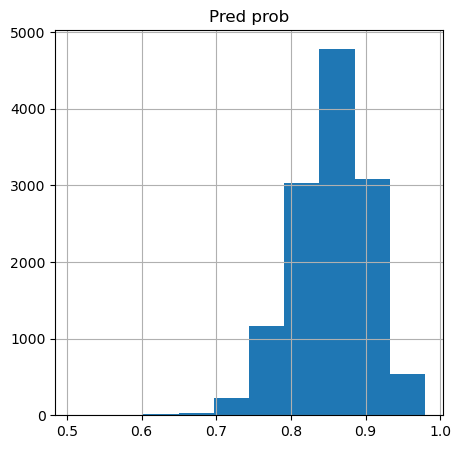

In [20]:
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
mid_fin2[["Pred prob"]].hist(ax=ax) #better or worse probability distribution, with midterm as numbers

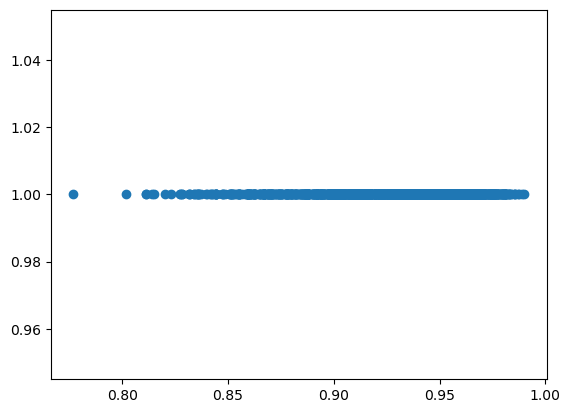

In [63]:
plt.scatter(x= mid_fin2["Pred prob"], y=mid_fin2["Pred"]) #model predicted everything as going to do better, but alot were not (shown at 0)

In [64]:
#BETTER/W binary but with different categories
betters = mid_fin2[ mid_fin2["Midterm_Grade"].isin(dont_care)==False]
betters = betters[ betters["Midterm_Grade_N"]<=betters["OFFICIAL_GRADE"]]
betters = betters.drop(["Pred prob", "Pred"], axis=1)
betters["OGRADEBISPLIT"]=np.where(betters["OFFICIAL_GRADE"]-1>=betters["Midterm_Grade_N"],1,0)

betters["OGRADEBISPLIT"].value_counts()

OGRADEBISPLIT
1    731
0    502
Name: count, dtype: int64

In [23]:
lr234_fit = smf.logit("OGRADEBISPLIT ~ COURSE_ID + SUBJECT_CODE + Midterm_Grade_N + C(ETHNIC_REPORTING_DESCR, Treatment(reference='White')) + CATALOG_NUMBER + CREDIT_TOTAL + TERM_TEST_CREDITS + MATH_T", data=betters).fit() #C(Midterm_Grade, Treatment(reference='C'))
print(lr234_fit.summary())

y=betters["OGRADEBISPLIT"]
X=betters[["MATH_T", "COURSE_ID", "CATALOG_NUMBER", "TERM_TEST_CREDITS", "ETHNIC_REPORTING_DESCR", "SUBJECT_CODE", "Midterm_Grade_N", "CREDIT_TOTAL"]]

betters["Pred prob"] = lr234_fit.predict(X) #giving predictive probability
betters["Pred"] = np.where(betters["Pred prob"]>.5,1,0)

confusion_matrix(y, betters["Pred"])

Optimization terminated successfully.
         Current function value: 0.630619
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          OGRADEBISPLIT   No. Observations:                 1233
Model:                          Logit   Df Residuals:                     1218
Method:                           MLE   Df Model:                           14
Date:                Mon, 02 Oct 2023   Pseudo R-squ.:                 0.06686
Time:                        11:49:13   Log-Likelihood:                -777.55
converged:                       True   LL-Null:                       -833.26
Covariance Type:            nonrobust   LLR p-value:                 2.972e-17
                                                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------

array([[178, 324],
       [125, 606]], dtype=int64)

array([<Axes: title={'center': 'Pred prob'}>], dtype=object)

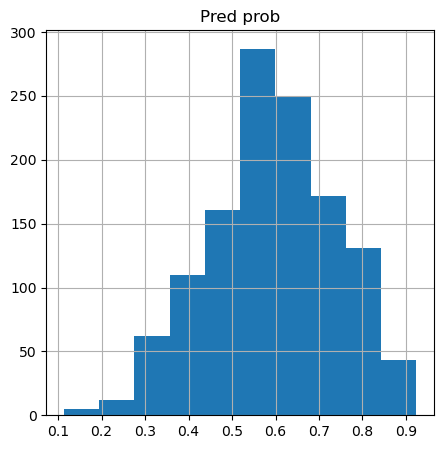

In [24]:
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
betters[["Pred prob"]].hist(ax=ax)

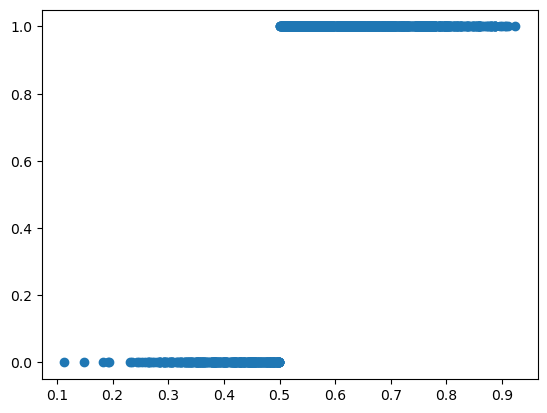

In [25]:
plt.scatter(x= betters["Pred prob"], y=betters["Pred"]) #model predicted everything as going to do better, but alot were not (shown at 0)

In [26]:
worses = mid_fin2[ mid_fin2["Midterm_Grade"].isin(dont_care)==False]
worses = worses[ worses["Midterm_Grade_N"]>=worses["OFFICIAL_GRADE"]]
worses = betters.drop(["Pred prob", "Pred"], axis=1)
worses["OGRADEBISPLIT"]=np.where(worses["OFFICIAL_GRADE"]<=worses["Midterm_Grade_N"],1,0)

worses["OGRADEBISPLIT"].value_counts()

OGRADEBISPLIT
0    915
1    318
Name: count, dtype: int64

In [27]:
lr2345_fit = smf.logit("OGRADEBISPLIT ~ COURSE_ID + SUBJECT_CODE + Midterm_Grade_N + C(ETHNIC_REPORTING_DESCR, Treatment(reference='White')) + CATALOG_NUMBER + CREDIT_TOTAL + TERM_TEST_CREDITS + MATH_T", data=worses).fit() #C(Midterm_Grade, Treatment(reference='C'))
print(lr234_fit.summary())

y=worses["OGRADEBISPLIT"]
X=worses[["MATH_T", "COURSE_ID", "CATALOG_NUMBER", "TERM_TEST_CREDITS", "ETHNIC_REPORTING_DESCR", "SUBJECT_CODE", "Midterm_Grade_N", "CREDIT_TOTAL"]]

worses["Pred prob"] = lr2345_fit.predict(X) #giving predictive probability
worses["Pred"] = np.where(worses["Pred prob"]>.5,1,0)

confusion_matrix(y, betters["Pred"])

Optimization terminated successfully.
         Current function value: 0.539810
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          OGRADEBISPLIT   No. Observations:                 1233
Model:                          Logit   Df Residuals:                     1218
Method:                           MLE   Df Model:                           14
Date:                Mon, 02 Oct 2023   Pseudo R-squ.:                 0.06686
Time:                        11:49:14   Log-Likelihood:                -777.55
converged:                       True   LL-Null:                       -833.26
Covariance Type:            nonrobust   LLR p-value:                 2.972e-17
                                                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------

array([[204, 711],
       [ 99, 219]], dtype=int64)

## Not logistic

In [28]:
#Linear reg but with midterm letters
from statsmodels.formula.api import ols

model = ols("""OFFICIAL_GRADE ~ SUBJECT_CODE + Midterm_Grade_N + CATALOG_NUMBER + TERM_TEST_CREDITS + CREDIT_TOTAL + MATH_T""", data=mid_fin2)
fitted_model = model.fit() 

#mid_fin4["Pred prob"] = fitted_model.predict(X)

print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:         OFFICIAL_GRADE   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     2392.
Date:                Mon, 02 Oct 2023   Prob (F-statistic):               0.00
Time:                        11:49:14   Log-Likelihood:                -9884.4
No. Observations:               12865   AIC:                         1.978e+04
Df Residuals:                   12858   BIC:                         1.983e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.2122      0.05

In [29]:
#Linear reg but with midterm letters
model = ols("""OFFICIAL_GRADE ~ SUBJECT_CODE + C(Midterm_Grade, Treatment(reference='C')) + CATALOG_NUMBER + TERM_TEST_CREDITS + CREDIT_TOTAL + MATH_T""", data=mid_fin2)
fitted_model = model.fit() 

#mid_fin4["Pred prob"] = fitted_model.predict(X)

print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:         OFFICIAL_GRADE   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     1041.
Date:                Mon, 02 Oct 2023   Prob (F-statistic):               0.00
Time:                        11:49:14   Log-Likelihood:                -9828.7
No. Observations:               12865   AIC:                         1.969e+04
Df Residuals:                   12850   BIC:                         1.980e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [30]:
mid_fin11[["TERM", "COURSE_ID", "SUBJECT_CODE", "CATALOG_NUMBER", "TERM_TEST_CREDITS", "CREDIT_TOTAL", "MATH_T", "Midterm_Grade", "OFFICIAL_GRADE"]].corr()

,TERM,COURSE_ID,SUBJECT_CODE,CATALOG_NUMBER,TERM_TEST_CREDITS,CREDIT_TOTAL,MATH_T,Midterm_Grade,OFFICIAL_GRADE
TERM,1.000000,0.008381,-0.060007,0.022843,-0.184124,0.004160,-0.230826,-0.114777,-0.108743
COURSE_ID,0.008381,1.000000,0.562280,0.204707,-0.156082,-0.087103,-0.096471,-0.118545,-0.017401
SUBJECT_CODE,-0.060007,0.562280,1.000000,0.387218,-0.168465,-0.095875,-0.107450,-0.068625,-0.024781
CATALOG_NUMBER,0.022843,0.204707,0.387218,1.000000,0.070542,0.021134,0.092180,-0.082863,-0.034190
TERM_TEST_CREDITS,-0.184124,-0.156082,-0.168465,0.070542,1.000000,0.101441,0.466739,0.119947,0.087593
CREDIT_TOTAL,0.004160,-0.087103,-0.095875,0.021134,0.101441,1.000000,0.078571,0.048919,-0.018841
MATH_T,-0.230826,-0.096471,-0.107450,0.092180,0.466739,0.078571,1.000000,0.167217,0.079373
Midterm_Grade,-0.114777,-0.118545,-0.068625,-0.082863,0.119947,0.048919,0.167217,1.000000,0.284072
OFFICIAL_GRADE,-0.108743,-0.017401,-0.024781,-0.034190,0.087593,-0.018841,0.079373,0.284072,1.000000


In [31]:
#correlation with better & worse
betters[["TERM", "COURSE_ID", "SUBJECT_CODE", "CATALOG_NUMBER", "TERM_TEST_CREDITS", "CREDIT_TOTAL", "MATH_T", "Midterm_Grade_N", "OFFICIAL_GRADE"]].corr()
#OFFICIAL_GRADE_bi ~ SUBJECT_CODE + Midterm_Grade_N + C(ETHNIC_REPORTING_DESCR, Treatment(reference='White'))

,TERM,COURSE_ID,SUBJECT_CODE,CATALOG_NUMBER,TERM_TEST_CREDITS,CREDIT_TOTAL,MATH_T,Midterm_Grade_N,OFFICIAL_GRADE
TERM,1.000000,0.029824,-0.046840,0.020227,-0.199166,-0.005886,-0.238965,-0.118823,-0.108428
COURSE_ID,0.029824,1.000000,0.542584,0.190161,-0.154606,-0.065558,-0.103811,-0.121870,0.027054
SUBJECT_CODE,-0.046840,0.542584,1.000000,0.392000,-0.162067,-0.095140,-0.107653,-0.086239,-0.066687
CATALOG_NUMBER,0.020227,0.190161,0.392000,1.000000,0.066486,0.028631,0.094317,-0.095638,-0.030083
TERM_TEST_CREDITS,-0.199166,-0.154606,-0.162067,0.066486,1.000000,0.100665,0.471047,0.134139,0.204865
CREDIT_TOTAL,-0.005886,-0.065558,-0.095140,0.028631,0.100665,1.000000,0.082007,0.038799,0.021136
MATH_T,-0.238965,-0.103811,-0.107653,0.094317,0.471047,0.082007,1.000000,0.162485,0.247465
Midterm_Grade_N,-0.118823,-0.121870,-0.086239,-0.095638,0.134139,0.038799,0.162485,1.000000,0.559653
OFFICIAL_GRADE,-0.108428,0.027054,-0.066687,-0.030083,0.204865,0.021136,0.247465,0.559653,1.000000


In [32]:
mid_fin2[["TERM", "COURSE_ID", "SUBJECT_CODE", "CATALOG_NUMBER", "TERM_TEST_CREDITS", "CREDIT_TOTAL", "MATH_T", "Midterm_Grade_N", "OFFICIAL_GRADE"]].corr()

,TERM,COURSE_ID,SUBJECT_CODE,CATALOG_NUMBER,TERM_TEST_CREDITS,CREDIT_TOTAL,MATH_T,Midterm_Grade_N,OFFICIAL_GRADE
TERM,1.000000,0.059499,-0.100330,-0.051645,-0.131987,0.003469,-0.124883,0.010927,-0.004451
COURSE_ID,0.059499,1.000000,0.226619,-0.043361,-0.028732,-0.079694,-0.038616,0.143032,0.131111
SUBJECT_CODE,-0.100330,0.226619,1.000000,0.289152,-0.053352,-0.013035,-0.083615,-0.193456,-0.149028
CATALOG_NUMBER,-0.051645,-0.043361,0.289152,1.000000,0.131935,0.071790,0.051738,-0.102388,-0.071678
TERM_TEST_CREDITS,-0.131987,-0.028732,-0.053352,0.131935,1.000000,0.056745,0.433773,0.170630,0.212359
CREDIT_TOTAL,0.003469,-0.079694,-0.013035,0.071790,0.056745,1.000000,0.054472,0.026584,0.036490
MATH_T,-0.124883,-0.038616,-0.083615,0.051738,0.433773,0.054472,1.000000,0.193609,0.207368
Midterm_Grade_N,0.010927,0.143032,-0.193456,-0.102388,0.170630,0.026584,0.193609,1.000000,0.719495
OFFICIAL_GRADE,-0.004451,0.131111,-0.149028,-0.071678,0.212359,0.036490,0.207368,0.719495,1.000000


In [33]:
#letters to numbers, then make categories
mid_fin3["Midterm_Grade"] = pd.to_numeric(mid_fin3["Midterm_Grade"].replace("A", 4.0).replace("AB", 3.5).replace("B", 3.0).replace("BC", 2.5).replace("C", 2.0).replace("D", 1.0).replace("F", 0.0) \
.replace("I", 0.0).replace("UD", 0.0).replace("NW", 0.0).replace("DR", 0.0).replace("N", 0.0))

mid_fin3["Midterm_Grade_C"] = mid_fin3["Midterm_Grade"].apply(lambda x: "C Range" if (x<2.5 and x>=2) \
                                       else ("A Range" if x>=3.6 \
                                           else ("AB Range" if (x<3.6 and x>=3.3) \
                                                else ("B Range" if (x<3.3 and x>=3) \
                                                     else ("BC Range" if (x<3 and x>=2.5) \
                                                          else ("D/F Range" if x<1.99
                                                               else "_None" ) ) ))))
mid_fin3["Midterm_Grade_C"] = mid_fin3["Midterm_Grade_C"].astype("category")
      

mid_fin3["OFFICIAL_GRADE_C"] =mid_fin3["OFFICIAL_GRADE"].apply(lambda x: "C Range" if (x<2.5 and x>=2) \
                                       else ("A Range" if x>=3.6 \
                                           else ("AB Range" if (x<3.6 and x>=3.3) \
                                                else ("B Range" if (x<3.3 and x>=3) \
                                                     else ("BC Range" if (x<3 and x>=2.5) \
                                                          else ("D/F Range" if x<1.99
                                                               else "_None" ) ) ))))
mid_fin3["OFFICIAL_GRADE_C"] =mid_fin3["OFFICIAL_GRADE_C"].astype("category")

### Combating uneven data

In [34]:
#SVC
#classification of better/w final grade
y= mid_fin2["OFFICIAL_GRADE_bi"]
X=mid_fin2[["MATH_T", "CATALOG_NUMBER", "TERM_TEST_CREDITS", "SUBJECT_CODE", "Midterm_Grade_N"]]

X_train, X_test, y_train, y_test = train_test_split(X, y) 

svc = SVC(verbose=0, class_weight='balanced').fit(X_train, y_train)
score = svc.score(X_test, y_test)
score

0.6468759714019272

In [35]:
#LINEAR SVC
#yy=mid_fin3["OFFICIAL_GRADE_C"] #ranges
yy= mid_fin2["OFFICIAL_GRADE_bi"]
XX=mid_fin2[["MATH_T", "CATALOG_NUMBER", "TERM_TEST_CREDITS", "SUBJECT_CODE", "Midterm_Grade_N"]]

X_train, X_test, y_train, y_test = train_test_split(XX, yy)

lsvc = LinearSVC(verbose=0, class_weight='balanced')
lsvc.fit(X_train, y_train)
score = lsvc.score(X_test, y_test)
score

C:\Users\kmconrad3\AppData\Local\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\kmconrad3\AppData\Local\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8340068386695679

In [36]:
#LINEAR SVC oversampler
y= mid_fin2["OFFICIAL_GRADE_bi"]
X=mid_fin2[["MATH_T", "CATALOG_NUMBER", "TERM_TEST_CREDITS", "SUBJECT_CODE", "Midterm_Grade_N"]]

from imblearn.over_sampling import RandomOverSampler
rs = RandomOverSampler(random_state=None)
X_resampled, y_resampled = rs.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled)

lsvc = LinearSVC(verbose=0, class_weight='balanced')
lsvc.fit(X_train, y_train)
#lsvc.predict_proba(X_test)
score = lsvc.score(X_test, y_test)
score
#lsvc.coef_[0]

ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (C:\Users\kmconrad3\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py)

In [37]:
#LINEAR SVC undersampler
y= mid_fin2["OFFICIAL_GRADE_bi"]
X=mid_fin2[["MATH_T", "CATALOG_NUMBER", "TERM_TEST_CREDITS", "SUBJECT_CODE", "Midterm_Grade_N"]]

from imblearn.under_sampling import RandomUnderSampler
rs = RandomUnderSampler(random_state=None)
X_resampled, y_resampled = rs.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled)

lsvc = LinearSVC(verbose=0, class_weight='balanced').fit(X_train, y_train)
score = lsvc.score(X_test, y_test)
score

ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (C:\Users\kmconrad3\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py)

## Graphs

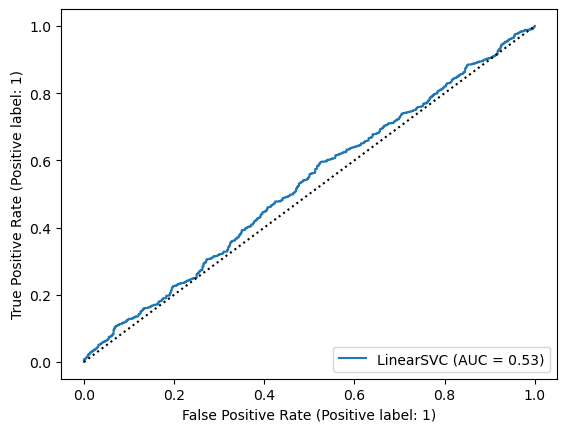

In [38]:
#r^2 curve graph for Better/W SVC
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(lsvc, X_test, y_test) #shows trade-off between sensitivity and specificity 
plt.plot([0, 1], [0, 1], ':k', label='merely guessing')
#AUC measures the performance of a binary classifier averaged across all possible decision thresholds, accuracy avg amoungst many thresholds

#score:gives predicted labels vs. AUC:gives predicted probability

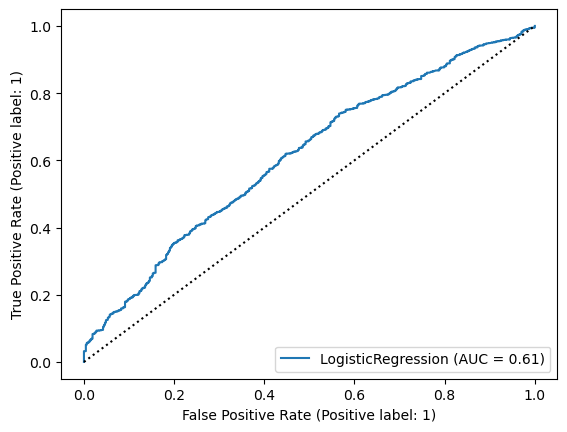

In [39]:
#r^2 curve graph for Better/W
RocCurveDisplay.from_estimator(lr, X_test, y_test) #shows trade-off between sensitivity and specificity 
plt.plot([0, 1], [0, 1], ':k', label='merely guessing')
#AUC measures the performance of a binary classifier averaged across all possible decision thresholds, accuracy avg amoungst many thresholds

#score:gives predicted labels vs. AUC:gives predicted probability

C:\Users\kmconrad3\AppData\Local\Temp\ipykernel_16740\3060397776.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(title='% Drop/Not of student\'s final grades', xticklabels=["Not Dropped", "Dropped"], xlabel="Official Grade Status")


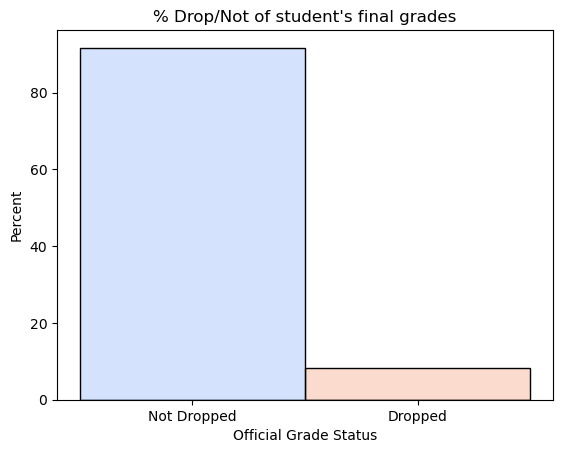

In [40]:
# % Drop/Not of people with midterms LOWER than BC
import seaborn as sns
#list(map(str, hi))
#hi = mid_fin1["OFFICIAL_GRADE"].unique().tolist()
mid_fin1["OFFICIAL_GRADE"] = mid_fin1["OFFICIAL_GRADE"].astype("str")
ax = sns.histplot(data=mid_fin1, x="OFFICIAL_GRADE", hue="OFFICIAL_GRADE", palette="coolwarm", stat="percent", discrete=True)
ax.set(title='% Drop/Not of student\'s final grades', xticklabels=["Not Dropped", "Dropped"], xlabel="Official Grade Status")
ax.get_legend().set_visible(False)
fig = ax.get_figure()
fig.savefig("pic dn")

C:\Users\kmconrad3\AppData\Local\Temp\ipykernel_16740\1129398188.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(title=' % Better/Worse of student\'s final grades', xticklabels=["Better", "Worse"], xlabel="Official Grade Status")


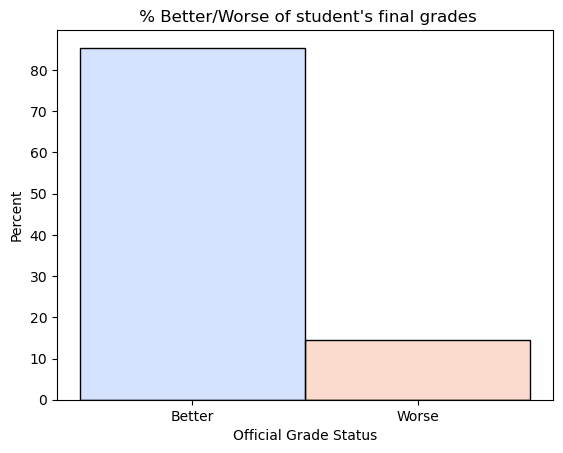

In [41]:
# % B/W of people with midterms LOWER than BC
mid_fin2["OFFICIAL_GRADE_bi"] = mid_fin2["OFFICIAL_GRADE_bi"].astype("str")
ax = sns.histplot(data=mid_fin2, x="OFFICIAL_GRADE_bi", hue="OFFICIAL_GRADE_bi", palette="coolwarm", stat="percent", discrete=True)
ax.set(title=' % Better/Worse of student\'s final grades', xticklabels=["Better", "Worse"], xlabel="Official Grade Status")
ax.get_legend().set_visible(False)
fig = ax.get_figure()
fig.savefig("pic bw")

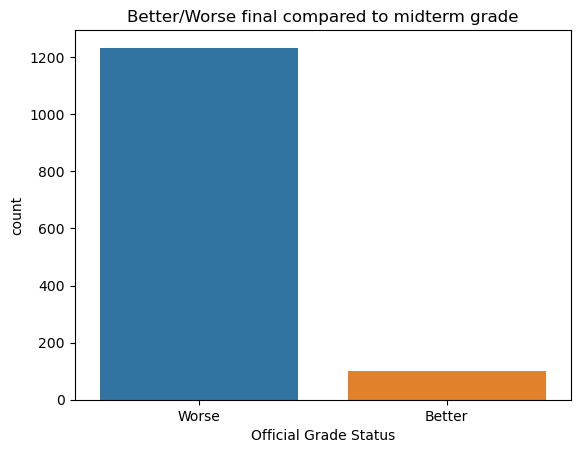

In [42]:
#Better/W final grade of people with midterms below BC COUNTS
mid_fin22 = mid_fin2.copy(deep=True)
mid_fin22 = mid_fin22[ mid_fin22["Midterm_Grade"].isin(dont_care)==False]
ax = sns.countplot(x=mid_fin22["OFFICIAL_GRADE_bi"])
ax.set(title='Better/Worse final compared to midterm grade', xticklabels=["Worse", "Better"], xlabel="Official Grade Status")
fig = ax.get_figure()
fig.savefig("pic bw")

C:\Users\kmconrad3\AppData\Local\Temp\ipykernel_16740\3059142209.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


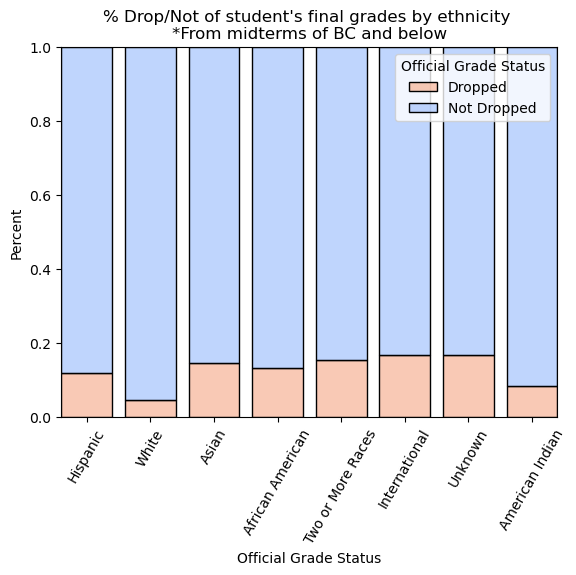

In [67]:
#% Drop/Not by ethnicity
#mid_fin1["OFFICIAL_GRADE"] = mid_fin1["OFFICIAL_GRADE"].astype("str")
ax = sns.histplot(data=mid_fin1, x="ETHNIC_REPORTING_DESCR", hue="OFFICIAL_GRADE", palette="coolwarm", stat="percent",  multiple="fill", shrink=.8)
ax.set(title='% Drop/Not of student\'s final grades by ethnicity \n*From midterms of BC and below', xlabel="Official Grade Status")
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
ax.legend(title='Official Grade Status', labels=['Dropped', 'Not Dropped'])
fig = ax.get_figure()
fig.savefig("pic dn e")

C:\Users\kmconrad3\AppData\Local\Temp\ipykernel_16740\2682350470.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


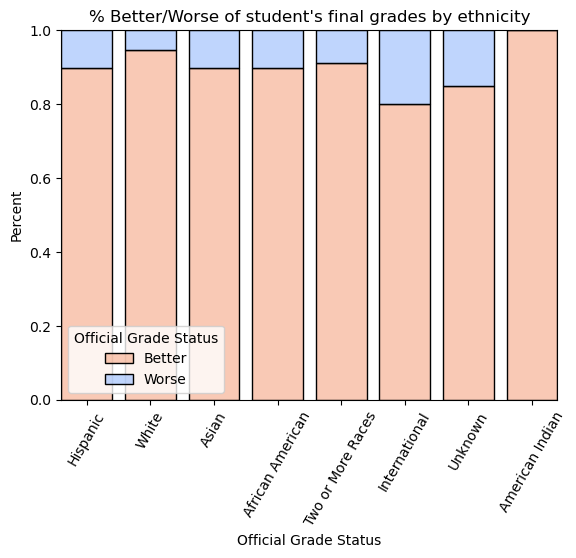

In [75]:
#% Better/worse by ethnicity
mid_fin2["OFFICIAL_GRADE"] = mid_fin2["OFFICIAL_GRADE"].astype("str")
ax = sns.histplot(data=mid_fin2, x="ETHNIC_REPORTING_DESCR", hue="OFFICIAL_GRADE_bi", palette="coolwarm", stat="percent",  multiple="fill", shrink=.8)
ax.set(title='% Better/Worse of student\'s final grades by ethnicity', xlabel="Official Grade Status")
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
ax.legend(title='Official Grade Status', labels=['Better', 'Worse'])
fig = ax.get_figure()
fig.savefig("pic bw e")

OFFICIAL_GRADE
2.0    353
3.0    308
2.5    261
0.0    156
3.5    108
1.0     97
4.0     49
Name: count, dtype: int64

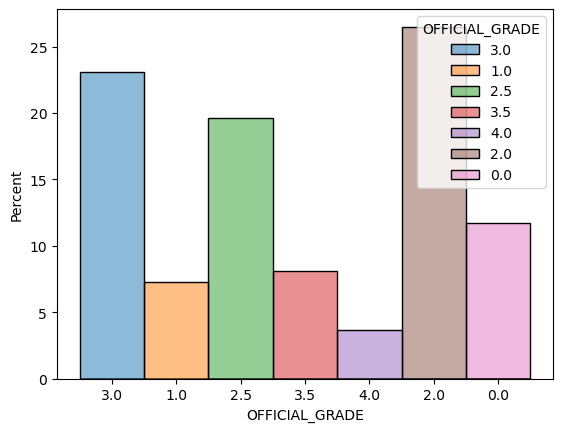

In [88]:
#final GPAs of people with midterms below BC
mid_fin22 = mid_fin2.copy(deep=True)
mid_fin22 = mid_fin22[ mid_fin22["Midterm_Grade"].isin(dont_care)==False]
#sns.countplot(x=mid_fin22["OFFICIAL_GRADE"])

ax = sns.histplot(data=mid_fin22, x="OFFICIAL_GRADE", hue="OFFICIAL_GRADE", stat="percent", discrete=True)

mid_fin22["OFFICIAL_GRADE"].value_counts() #out of 1332

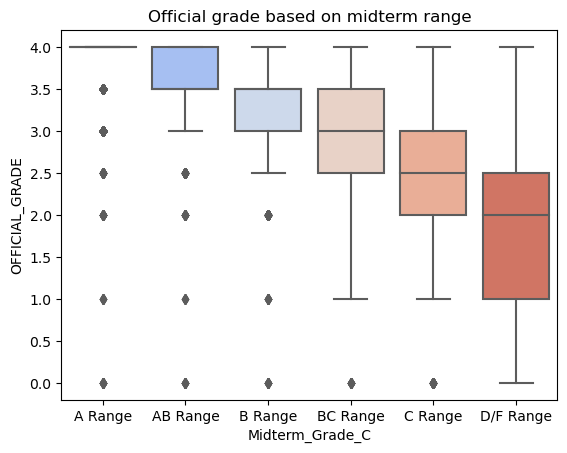

In [46]:
#The average final grade for each category of midterm grade
ax = sns.boxplot(data=mid_fin3, x="Midterm_Grade_C", y="OFFICIAL_GRADE", showcaps=True, palette="coolwarm")
ax.set(title='Official grade based on midterm range')
fig = ax.get_figure()
fig.savefig("pic box")

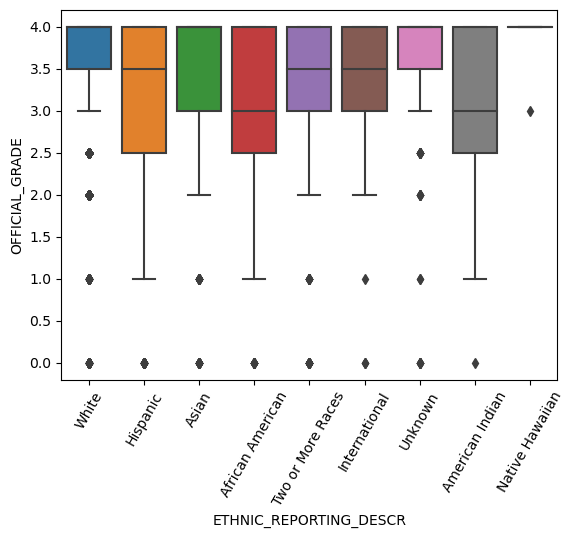

In [49]:
#The average final grade for each ethnicity
mid_fin2["OFFICIAL_GRADE"] = mid_fin2["OFFICIAL_GRADE"].astype("float")
ax = sns.boxplot(data=mid_fin2, x="ETHNIC_REPORTING_DESCR", y="OFFICIAL_GRADE", showcaps=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
fig = ax.get_figure()
fig.savefig("all eth box")

C:\Users\kmconrad3\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\kmconrad3\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


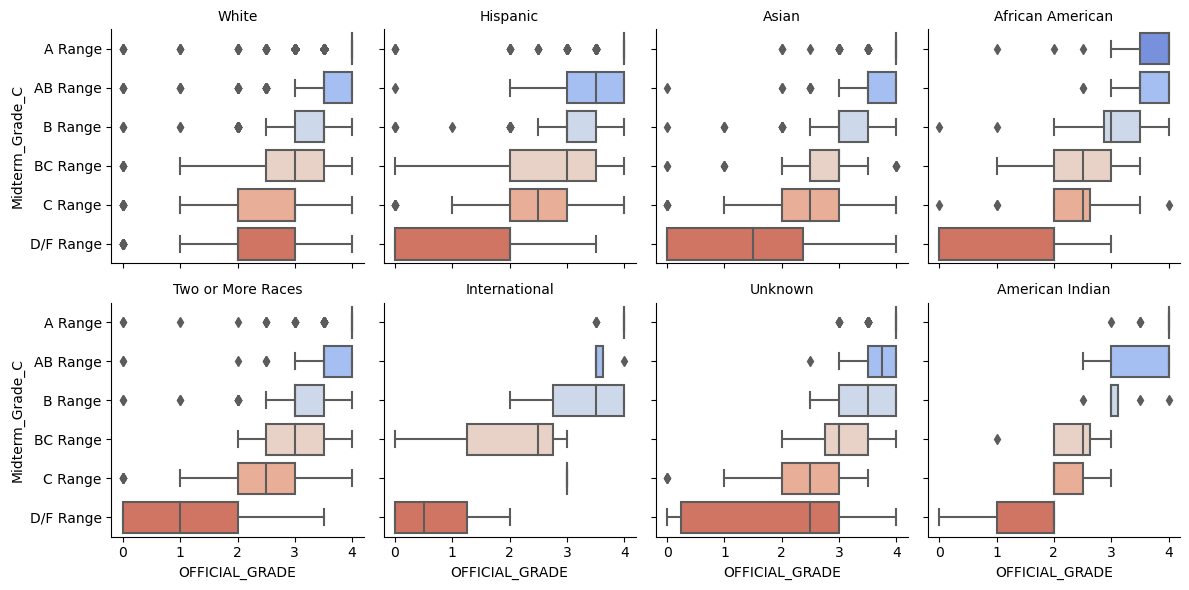

In [57]:
#exclude native hawaiian cuz there is like 5 ppl
g = sns.FacetGrid(mid_fin3[mid_fin3["ETHNIC_REPORTING_DESCR"] != "Native Hawaiian"], col="ETHNIC_REPORTING_DESCR", col_wrap=4)
g.map(sns.boxplot, "OFFICIAL_GRADE", "Midterm_Grade_C", palette="coolwarm")
g.set_titles("{col_name}")
fig = ax.get_figure()
fig.savefig("eth box")

In [ ]:
ax = sns.kdeplot(mid_fin3, x ='Midterm_Grade', hue='OFFICIAL_GRADE_C', palette=sns.cubehelix_palette(start=2), fill=True) #mass/volume